In [4]:
import deepquantum as dq
import deepquantum.photonic as dqp
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [5]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', 
                       backend='gaussian', 
                       name='try', noise=False)
# cir.ps(0, 0.5)
cir.bs_ry([0, 1], inputs=[torch.pi])
# cir.loss(0.1, inputs=0)
# cir.bs(wires=[0, 1], inputs=[torch.pi, np.nan])

print(cir.get_unitary())

#线路可视化
cir.draw('pic/CM_circ_num_ME.svg')

tensor([[-4.3711e-08+0.j, -1.0000e+00-0.j],
        [ 1.0000e+00+0.j, -4.3711e-08+0.j]])


In [6]:
Ns: int = 1
Nm: int = 2
NL: int = 3
eta: float = 0
delta_k: float = 0
r_k: float = 0
phi_k: float = [0,1]
shots: int = 1000
init_state: any = 'vac'
s_r: float = 0
s_phi: float = 0
m1_r: float = 0
m1_phi: float = 0

N_total = Ns + Nm + NL
theta = 2*eta - np.pi

cir = dq.QumodeCircuit(nmode=N_total, init_state=init_state, 
                    backend='gaussian', 
                    name='try', noise=False,
                    mu = 0, sigma = 0)

# s0,m1, two-mode squeezed vacuum (TMSV) state 
# # S(r,theta)
cir.s2(wires=[0, 1], r=2, theta=0)

# m2, single-mode squeezing vacuum (SMSV) state
# for i in range(Nm+NL-1):
#     cir.s(wires=2+i, r=r_k, theta=phi_k)

for i in range(Nm+NL-1):
    cir.s(wires=2+i, r=r_k, theta=phi_k[i % 2])

for i in range(N_total-2):
    for j in range(N_total-i-2):
        cir.bs_ry(wires=[j+1,j+2], inputs=theta)
        cir.ps(j+1, [delta_k])

#线路可视化
cir.draw('pic/CM_circ_num_ME{}.svg'.format(N_total))

In [7]:
state = cir.forward()

# 这里measure_homodyne测量对应的物理量是正交算符 $$\hat x$$ 和 $$\hat p$$ 的值，
# photon_number_mean_var对应的是每个mode的光子数的平均值和方差。
# Use ``xxpp`` convention
# 第一个光子：x1，x2，... p1，p2...
# 第二个光子：x1，x2，... p1，p2...

sample = cir.measure_homodyne(shots=shots)

# ( [平均值], [方差] )
photon_number = cir.photon_number_mean_var()
print('number of modes: ', N_total)
print('sample: ', sample)
print('sample[0]: ', sample[0])
print('size of sample: ', sample.size())
print('\n全部qubit的每光子数的平均值和方差: ', photon_number)

number of modes:  6
sample:  tensor([[-5.0272, -0.7699, -0.5477,  ...,  1.0823, -0.6290,  4.6321],
        [-3.2292,  0.3819,  0.1637,  ..., -1.0407,  0.6166, -8.5625],
        [-0.9431, -0.5466,  1.6056,  ...,  0.9670, -0.1847, -4.8956],
        ...,
        [-2.8619, -0.2124,  0.3114,  ...,  1.5610,  1.9356, -1.1314],
        [ 0.7614,  1.8502,  1.4030,  ..., -1.1251,  1.4044,  4.7016],
        [-5.5339,  0.8549,  0.6630,  ...,  0.3192, -0.1479, -3.3662]])
sample[0]:  tensor([-5.0272, -0.7699, -0.5477, -1.6637, -1.0814, -4.9400, -4.7676, -0.3967,
        -0.3819,  1.0823, -0.6290,  4.6321])
size of sample:  torch.Size([1000, 12])

全部qubit的每光子数的平均值和方差:  (tensor([13.1541,  0.0000,  0.0000,  0.0000,  0.0000, 13.1541]), tensor([186.1849,   0.0000,   0.0000,   0.0000,   0.0000, 186.1849]))


In [8]:
s_x = np.array(sample.T[:Ns]) 
s_p = np.array(sample.T[Ns+Nm+NL:2*Ns+Nm+NL][:])
m_x = np.array(sample.T[Ns:(Ns+Nm)][:]) 
m_p = np.array(sample.T[2*Ns+Nm+NL:2*Ns+2*Nm+NL][:])
e_x = np.array(sample.T[Ns+Nm:Ns+Nm+NL][:])
e_p = np.array(sample.T[2*Ns+2*Nm+NL:][:])

print('s_x: ', s_x)
print('s_p: ', s_p)
print('m_x: ', m_x)
print('m_p: ', m_p)
print('e_x: ', e_x)
print('e_p: ', e_p)
# print('e_p: ', e_p)
# tensor([-1.7606, -1.8317,  0.1675,  0.0505,  0.4172,  0.1999, -0.9365, 0.7595, -0.5110, 
#         -0.1866,  0.0076,  2.5539,  0.6549,  0.2298, -0.5049, -2.2482, 0.2991, -0.8218])        #    s_xj   m1x      m2x     e1x       s_xk   m1p      m2p      e1p  

s_x:  [[-5.02715826e+00 -3.22921228e+00 -9.43117142e-01 -4.28698349e+00
  -5.10547876e-01  1.48171604e+00  2.26396394e+00 -7.42707205e+00
  -3.86159396e+00 -3.76988387e+00 -2.08261824e+00  2.17558432e+00
   6.12751436e+00 -1.97416198e+00 -5.69470453e+00 -6.06998682e+00
  -2.17790699e+00  1.22434320e+01 -6.26728821e+00  3.67528224e+00
   3.21667528e+00 -3.47984457e+00 -3.80818653e+00  1.87912726e+00
   1.53216815e+00  5.44102001e+00 -2.16513887e-01 -9.20855701e-02
   1.58152175e+00 -3.55353475e+00 -5.37812853e+00 -5.65144682e+00
   3.08049941e+00 -7.24451733e+00  7.75376844e+00 -7.95543051e+00
  -6.76249552e+00 -4.65660185e-01 -6.15034246e+00  3.41077352e+00
  -2.78532982e+00  1.22185588e+00  2.70311689e+00 -8.01352978e+00
   7.87309265e+00  2.05300140e+00 -5.17079067e+00  8.48075294e+00
   1.07612209e+01 -4.76646185e+00 -2.81717396e+00 -1.18427448e+01
  -5.49125481e+00 -1.43170190e+00  1.32590857e+01  5.14364386e+00
   8.68539810e+00  2.50239635e+00 -2.77528167e+00  7.69467711e-01
   5

(-18.55588254928589, 18.23252401351929, -18.039985847473144, 17.75374240875244)

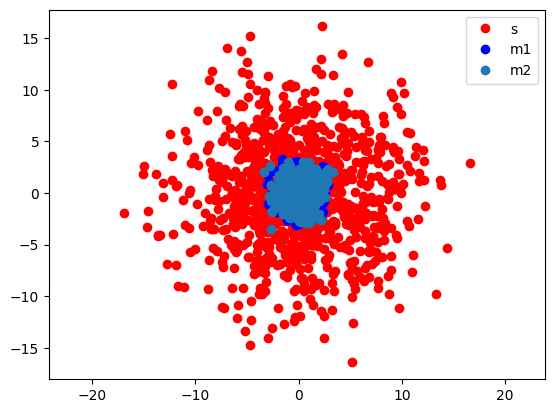

In [9]:
import matplotlib.pyplot as plt
plt.plot(s_x[0], s_p[0], 'ro', label='s')
plt.plot(m_x[0], m_p[0], 'bo', label='m1')
plt.plot(m_x[1], m_p[1], 'o', label='m2')
# plt.plot(e_x[0], e_p[0], 'go', label='e1')
# plt.plot(e_x[1], e_p[1], 'o', label='e2')
plt.legend()
plt.axis('equal')

(-18.55588254928589,
 18.23252401351929,
 -3.3757529497146606,
 3.6197667360305785)

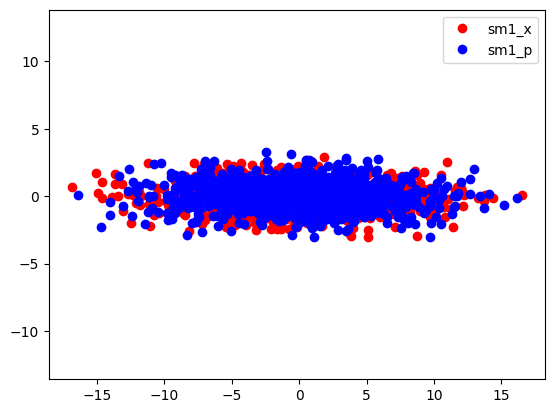

In [10]:
import matplotlib.pyplot as plt
plt.plot(s_x[0], m_x[0], 'ro', label='sm1_x')
plt.plot(s_p[0], m_p[0], 'bo', label='sm1_p')

plt.legend()
plt.axis('equal')

In [11]:
def get_sigma(xj, xk):
    return np.cov(xj, xk)

In [12]:
get_sigma(s_x, s_p)

array([[27.44333345, -0.0300116 ],
       [-0.0300116 , 25.97877422]])

In [13]:
sigma_s = np.zeros((2,2))
np.size(sigma_s)

4

In [14]:
sigma_s = np.zeros((2,2))
sigma_m1 = np.zeros((2,2))
sigma_m2 = np.zeros((2,2))

sigma_s = get_sigma(s_x, s_p)
sigma_m1 = get_sigma(m_x[0], m_p[0])
sigma_m2 = get_sigma(m_x[1], m_p[1])
        
sigma_s, sigma_m1, sigma_m2

(array([[27.44333345, -0.0300116 ],
        [-0.0300116 , 25.97877422]]),
 array([[0.98812675, 0.01897371],
        [0.01897371, 1.0553673 ]]),
 array([[0.98668746, 0.05215524],
        [0.05215524, 1.05783365]]))

$$\boldsymbol{\sigma} = \begin{bmatrix}
\sigma_{xx,aa} & \sigma_{xp,aa} & \sigma_{xx,ab} & \sigma_{xp,ab} \\
\sigma_{px,aa} & \sigma_{pp,aa} & \sigma_{px,ab} & \sigma_{pp,ab} \\
\sigma_{xx,ba} & \sigma_{xp,ba} & \sigma_{xx,bb} & \sigma_{xp,bb} \\
\sigma_{px,ba} & \sigma_{pp,ba} & \sigma_{px,bb} & \sigma_{pp,bb}
\end{bmatrix}$$

In [15]:
sigma_m12 = np.zeros((2*Nm,2*Nm))
sigma_sm1 = np.zeros((2*(Ns+1),2*(Ns+1)))
sigma_sm2 = np.zeros((2*(Ns+1),2*(Ns+1)))

choose = [['xxaa', 'xpaa', 'xxab', 'xpab'],
          ['pxaa', 'ppaa', 'pxab', 'ppab'],
          ['xxba', 'xpba', 'xxbb', 'xpbb'],
          ['pxba', 'ppba', 'pxbb', 'ppbb']]
index_m12 = {'xa':m_x[0], 'pa':m_p[0], 'xb':m_x[1], 'pb':m_p[1]}
index_sm1 = {'xa':s_x, 'pa':s_p, 'xb':m_x[0], 'pb':m_p[0]}
index_sm2 = {'xa':s_x, 'pa':s_p, 'xb':m_x[1], 'pb':m_p[1]}

for i in range(Nm*2):
    for j in range(Nm*2):
        sigma_m12[i][j] = get_sigma( index_m12[choose[i][j][0]+choose[i][j][2]], 
                               index_m12[choose[i][j][1]+choose[i][j][3]] )[0][1]
        sigma_sm1[i][j] = get_sigma( index_sm1[choose[i][j][0]+choose[i][j][2]], 
                               index_sm1[choose[i][j][1]+choose[i][j][3]] )[0][1]
        sigma_sm2[i][j] = get_sigma( index_sm2[choose[i][j][0]+choose[i][j][2]],
                                 index_sm2[choose[i][j][1]+choose[i][j][3]] )[0][1]

print('sigma_m12: \n', sigma_m12)
print('sigma_sm1: \n', sigma_sm1)
print('sigma_sm2: \n', sigma_sm2)


sigma_m12: 
 [[0.98812675 0.01897371 0.0937218  0.00600049]
 [0.01897371 1.0553673  0.0411185  0.00575807]
 [0.0937218  0.0411185  0.98668746 0.05215524]
 [0.00600049 0.00575807 0.05215524 1.05783365]]
sigma_sm1: 
 [[ 2.74433334e+01 -3.00115959e-02 -2.53086236e-01 -8.27248454e-02]
 [-3.00115959e-02  2.59787742e+01 -2.73597116e-01 -2.33659076e-01]
 [-2.53086236e-01 -2.73597116e-01  9.88126752e-01  1.89737066e-02]
 [-8.27248454e-02 -2.33659076e-01  1.89737066e-02  1.05536730e+00]]
sigma_sm2: 
 [[27.44333345 -0.0300116   0.17037056 -0.31281433]
 [-0.0300116  25.97877422 -0.15526328 -0.0710431 ]
 [ 0.17037056 -0.15526328  0.98668746  0.05215524]
 [-0.31281433 -0.0710431   0.05215524  1.05783365]]


$$
\boldsymbol{\sigma} = \begin{bmatrix}
\sigma_{xx,aa} & \sigma_{xp,aa} & \sigma_{xx,ab} & \sigma_{xp,ab} & \sigma_{xx,ac} & \sigma_{xp,ac} \\
\sigma_{px,aa} & \sigma_{pp,aa} & \sigma_{px,ab} & \sigma_{pp,ab} & \sigma_{px,ac} & \sigma_{pp,ac} \\
\sigma_{xx,ba} & \sigma_{xp,ba} & \sigma_{xx,bb} & \sigma_{xp,bb} & \sigma_{xx,bc} & \sigma_{xp,bc} \\
\sigma_{px,ba} & \sigma_{pp,ba} & \sigma_{px,bb} & \sigma_{pp,bb} & \sigma_{px,bc} & \sigma_{pp,bc} \\
\sigma_{xx,ca} & \sigma_{xp,ca} & \sigma_{xx,cb} & \sigma_{xp,cb} & \sigma_{xx,cc} & \sigma_{xp,cc} \\
\sigma_{px,ca} & \sigma_{pp,ca} & \sigma_{px,cb} & \sigma_{pp,cb} & \sigma_{px,cc} & \sigma_{pp,cc}
\end{bmatrix}
$$

In [16]:
sigma_sm12 = np.zeros((2*(Ns+Nm), 2*(Ns+Nm)))

choose = [['xxaa', 'xpaa', 'xxab', 'xpab', 'xxac', 'xpac'],
          ['pxaa', 'ppaa', 'pxab', 'ppab', 'pxac', 'ppac'],
          ['xxba', 'xpba', 'xxbb', 'xpbb', 'xxbc', 'xpbc'],
          ['pxba', 'ppba', 'pxbb', 'ppbb', 'pxbc', 'ppbc'],
          ['xxca', 'xpca', 'xxcb', 'xpcb', 'xxcc', 'xpcc'],
          ['pxca', 'ppca', 'pxcb', 'ppcb', 'pxcc', 'ppcc']]
index_sm12 = {'xa':s_x, 'pa':s_p, 'xb':m_x[0], 'pb':m_p[0], 'xc':m_x[1], 'pc':m_p[1]}

for i in range(2*(Ns+Nm)):
    for j in range(2*(Ns+Nm)):
        sigma_sm12[i][j] = get_sigma( index_sm12[choose[i][j][0]+choose[i][j][2]], 
                               index_sm12[choose[i][j][1]+choose[i][j][3]] )[0][1]

print('sigma_sm12: \n', sigma_sm12)

sigma_sm12: 
 [[ 2.74433334e+01 -3.00115959e-02 -2.53086236e-01 -8.27248454e-02
   1.70370557e-01 -3.12814327e-01]
 [-3.00115959e-02  2.59787742e+01 -2.73597116e-01 -2.33659076e-01
  -1.55263280e-01 -7.10431031e-02]
 [-2.53086236e-01 -2.73597116e-01  9.88126752e-01  1.89737066e-02
   9.37218028e-02  6.00049146e-03]
 [-8.27248454e-02 -2.33659076e-01  1.89737066e-02  1.05536730e+00
   4.11184951e-02  5.75806726e-03]
 [ 1.70370557e-01 -1.55263280e-01  9.37218028e-02  4.11184951e-02
   9.86687461e-01  5.21552423e-02]
 [-3.12814327e-01 -7.10431031e-02  6.00049146e-03  5.75806726e-03
   5.21552423e-02  1.05783365e+00]]


In [17]:
def f(x):
    return (x+1/2)*np.log(x+1/2) - (x-1/2)*np.log(x-1/2)

In [18]:
def S(sigma):
    from scipy import linalg
    eigvals, _ = linalg.eig(sigma)
    return np.sum(f(eigvals))

In [19]:
I2_s_m1 = S(sigma_s) + S(sigma_m1) - S(sigma_sm1)
I2_s_m2 = S(sigma_s) + S(sigma_m2) - S(sigma_sm2)
I2_s_m12 = S(sigma_s) + S(sigma_m12) - S(sigma_sm12)

I3_s_m1_m2 = I2_s_m1 + I2_s_m2 - I2_s_m12

I2_s_m1, I2_s_m2, I2_s_m12, I3_s_m1_m2

((0.008154879274021809+0j),
 (0.00634097153711366+0j),
 (0.01458313767502517+0j),
 (-8.728686388970175e-05+0j))

In [20]:
from CM.TMI import TripartiteMutualInformation as tmi

a = tmi()
a.I3()

(6.805955139910225e-06+0j)